## EN4 TEMP (vertical mean: 0-200m; 200-600m)

In [1]:
import os
import xarray as xr
import numpy as np
import netCDF4
import seawater as sw
USER = os.environ['USER']

### vertically-regridded GOBAI O2 Obs

In [2]:
## monthly gridded O2/T/S data; 2004-2021
path = f'/glade/scratch/{USER}/DPLE-results'
filename = f'{path}/EN4_T_verti_regrid_195401-201712_monthly.nc'
nc = netCDF4.Dataset(filename, 'r')
gobai_o2 = nc.variables['T'][:,:,:,:-2] - 273.15
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:-2]
z_t = nc.variables['z_t'][:]
nc.close()

In [3]:
gobai_o2[0,0,:,:]

masked_array(
  data=[[25.9847412109375, 25.95721435546875, 25.9453125, ...,
         24.99420166015625, 24.8565673828125, 24.715301513671875],
        [25.775360107421875, 25.747314453125, 25.735504150390625, ...,
         24.824981689453125, 24.660430908203125, 24.490509033203125],
        [25.574920654296875, 25.543853759765625, 25.5306396484375, ...,
         24.617584228515625, 24.428955078125, 24.23468017578125],
        ...,
        [--, --, --, ..., --, 2.410797119140625, 2.4859619140625],
        [--, --, --, ..., --, --, 2.71343994140625],
        [--, --, --, ..., --, --, --]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True, False, False],
        [ True,  True,  True, ...,  True,  True, False],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=9.96921e+36,
  dtype=float32)

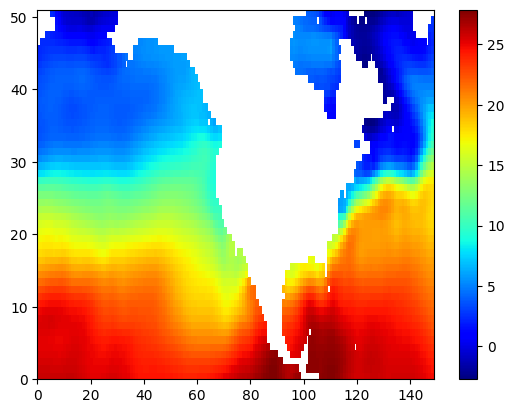

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
plt.pcolor(gobai_o2[0,0,:,:],cmap=cm.jet)
plt.colorbar()
plt.show()

### horizontally-regrided FOSI hindcast

In [5]:
path = f'/glade/scratch/{USER}/DPLE-results'
filename = f'{path}/FOSI_hindcast_TEMP_hori_regrid_195401-201712_monthly.nc'
dset = xr.open_dataset(filename)
fosi_o2 = dset['TEMP'].isel(y=range(14,65),x=range(169,318)).values
dset

<xarray.Dataset>
Dimensions:  (z_t: 35, time: 768, y: 80, x: 360)
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.277e+04 5.794e+04
  * time     (time) object 0255-02-01 00:00:00 ... 0319-01-01 00:00:00
    lat      (y, x) int64 ...
    lon      (y, x) int64 ...
Dimensions without coordinates: y, x
Data variables:
    TEMP     (time, z_t, y, x) float32 ...

In [7]:
fosi_o2 = np.ma.array(fosi_o2,mask=np.isnan(fosi_o2))

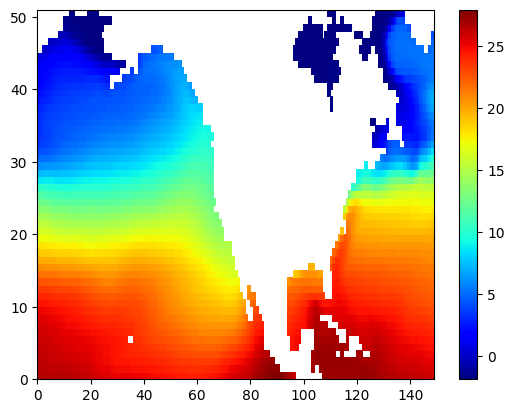

In [8]:
plt.pcolor(fosi_o2[0,0,:,:],cmap=cm.jet)
plt.colorbar()
plt.show()

In [9]:
np.shape(fosi_o2)

(768, 35, 51, 149)

In [10]:
np.shape(gobai_o2)

(768, 35, 51, 149)

In [12]:
np.where(gobai_o2>40)

(array([  0,   0,   0, ..., 767, 767, 767]),
 array([ 0,  0,  0, ..., 34, 34, 34]),
 array([ 0,  0,  0, ..., 50, 50, 50]),
 array([ 99, 100, 101, ..., 146, 147, 148]))

In [11]:
print(gobai_o2.max(),fosi_o2.max())

9.947445e+36 31.244045


In [13]:
gmask = gobai_o2.mask
emask = gobai_o2 > 40
fmask = fosi_o2.mask
gobai_o2.mask = gmask + fmask + emask
fosi_o2.mask = gmask + fmask + emask 

### prepare for vertical mean

In [14]:
path = f'/glade/scratch/{USER}/DPLE-results'
filename = f'{path}/DPLE-FOSI_hindcast_T_S_O2_1948-2017_monthly.nc'
dset = xr.open_dataset(filename)
dz = dset['dz'][:35].values/1e2 # m
dz

array([10.      , 10.      , 10.      , 10.      , 10.      , 10.      ,
       10.      , 10.      , 10.      , 10.      , 10.      , 10.      ,
       10.      , 10.      , 10.      , 10.      , 10.196808, 10.564484,
       11.059951, 11.67807 , 12.424133, 13.309678, 14.35141 , 15.571259,
       16.996796, 18.662125, 20.609024, 22.888521, 25.562471, 28.70575 ,
       32.40837 , 36.777725, 41.940308, 48.042236, 55.247543],
      dtype=float32)

In [15]:
from math import sin, cos, sqrt, atan2, radians
def geo_dis(lat1,lon1,lat2,lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [16]:
lon1 = lon + 0.5
lon1 = list(lon1)
lon1 = [lon1[0]-1] + lon1
lon1 = np.array(lon1)
lat1 = lat + 0.5
lat1 = list(lat1)
lat1 = [lat1[0]-1] + lat1
lat1 = np.array(lat1)
lon1

array([169.5, 170.5, 171.5, 172.5, 173.5, 174.5, 175.5, 176.5, 177.5,
       178.5, 179.5, 180.5, 181.5, 182.5, 183.5, 184.5, 185.5, 186.5,
       187.5, 188.5, 189.5, 190.5, 191.5, 192.5, 193.5, 194.5, 195.5,
       196.5, 197.5, 198.5, 199.5, 200.5, 201.5, 202.5, 203.5, 204.5,
       205.5, 206.5, 207.5, 208.5, 209.5, 210.5, 211.5, 212.5, 213.5,
       214.5, 215.5, 216.5, 217.5, 218.5, 219.5, 220.5, 221.5, 222.5,
       223.5, 224.5, 225.5, 226.5, 227.5, 228.5, 229.5, 230.5, 231.5,
       232.5, 233.5, 234.5, 235.5, 236.5, 237.5, 238.5, 239.5, 240.5,
       241.5, 242.5, 243.5, 244.5, 245.5, 246.5, 247.5, 248.5, 249.5,
       250.5, 251.5, 252.5, 253.5, 254.5, 255.5, 256.5, 257.5, 258.5,
       259.5, 260.5, 261.5, 262.5, 263.5, 264.5, 265.5, 266.5, 267.5,
       268.5, 269.5, 270.5, 271.5, 272.5, 273.5, 274.5, 275.5, 276.5,
       277.5, 278.5, 279.5, 280.5, 281.5, 282.5, 283.5, 284.5, 285.5,
       286.5, 287.5, 288.5, 289.5, 290.5, 291.5, 292.5, 293.5, 294.5,
       295.5, 296.5,

In [17]:
nlat = len(lat)
nlon = len(lon)
dx = np.zeros([nlat,nlon])
dy = dx.copy()
for ii in range(nlat):
    for jj in range(nlon):
        dx[ii,jj] = geo_dis(lat[ii],lon1[ii],lat[ii],lon1[ii+1])
        dy[ii,jj] = geo_dis(lat1[ii],lon[ii],lat1[ii+1],lon[ii])
darea = dx*dy # unit km*km

In [18]:
darea

array([[11950.49737935, 11950.49737935, 11950.49737935, ...,
        11950.49737935, 11950.49737935, 11950.49737935],
       [11892.79109731, 11892.79109731, 11892.79109731, ...,
        11892.79109731, 11892.79109731, 11892.79109731],
       [11831.4620919 , 11831.4620919 , 11831.4620919 , ...,
        11831.4620919 , 11831.4620919 , 11831.4620919 ],
       ...,
       [ 5616.74827805,  5616.74827805,  5616.74827805, ...,
         5616.74827805,  5616.74827805,  5616.74827805],
       [ 5423.50544715,  5423.50544715,  5423.50544715, ...,
         5423.50544715,  5423.50544715,  5423.50544715],
       [ 5228.61065751,  5228.61065751,  5228.61065751, ...,
         5228.61065751,  5228.61065751,  5228.61065751]])

In [19]:
dz = np.tile(dz[np.newaxis, :, np.newaxis, np.newaxis], [768, 1, nlat, nlon])
darea = np.tile(darea[np.newaxis, np.newaxis, :, :], [768, 35, 1, 1])
dvol = dz * darea
dvol = np.ma.array(dvol, mask=fosi_o2.mask)
uo2_gobai = gobai_o2 * dvol
uo2_fosi = fosi_o2 * dvol
np.shape(uo2_fosi)

(768, 35, 51, 149)

In [20]:
z_t

masked_array(data=[  5.     ,  15.     ,  25.     ,  35.     ,  45.     ,
                    55.     ,  65.     ,  75.     ,  85.     ,  95.     ,
                   105.     , 115.     , 125.     , 135.     , 145.     ,
                   155.     , 165.0984 , 175.47905, 186.29128, 197.66028,
                   209.71138, 222.57828, 236.40883, 251.37016, 267.6542 ,
                   285.48364, 305.11923, 326.86798, 351.09348, 378.22763,
                   408.78464, 443.3777 , 482.73672, 527.728  , 579.37286],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

## Upper 200 m Vertical Mean

In [21]:
gobai_o2_200m = np.sum(uo2_gobai[:, :20], axis=1) / np.sum(dvol[:, :20], axis=1)
gobai_o2_600m = np.sum(uo2_gobai[:, 20:35], axis=1) / np.sum(dvol[:, 20:35], axis=1)
fosi_o2_200m = np.sum(uo2_fosi[:, :20], axis=1) / np.sum(dvol[:, :20], axis=1)
fosi_o2_600m = np.sum(uo2_fosi[:, 20:35], axis=1) / np.sum(dvol[:, 20:35], axis=1)

In [22]:
dsf = xr.Dataset()
time = range(768)
dsf['EN4_T_0-200m'] = xr.DataArray(data=gobai_o2_200m, coords=dict(time=('time', time), lat=('lat', lat), lon=('lon', lon)), dims=('time','lat','lon'))
dsf['EN4_T_200-600m'] = xr.DataArray(data=gobai_o2_600m, coords=dict(time=('time', time), lat=('lat', lat), lon=('lon', lon)), dims=('time','lat','lon'))
dsf['FOSI_T_0-200m'] = xr.DataArray(data=fosi_o2_200m, coords=dict(time=('time', time), lat=('lat', lat), lon=('lon', lon)), dims=('time','lat','lon'))
dsf['FOSI_T_200-600m'] = xr.DataArray(data=fosi_o2_600m, coords=dict(time=('time', time), lat=('lat', lat), lon=('lon', lon)), dims=('time','lat','lon'))

In [23]:
dsf.load()

<xarray.Dataset>
Dimensions:          (time: 768, lat: 51, lon: 149)
Coordinates:
  * time             (time) int64 0 1 2 3 4 5 6 ... 761 762 763 764 765 766 767
  * lat              (lat) float32 15.0 16.0 17.0 18.0 ... 62.0 63.0 64.0 65.0
  * lon              (lon) float32 170.0 171.0 172.0 173.0 ... 316.0 317.0 318.0
Data variables:
    EN4_T_0-200m     (time, lat, lon) float64 24.97 24.93 24.85 ... nan nan nan
    EN4_T_200-600m   (time, lat, lon) float64 10.07 10.06 10.04 ... nan nan nan
    FOSI_T_0-200m    (time, lat, lon) float64 23.63 23.57 23.51 ... nan nan nan
    FOSI_T_200-600m  (time, lat, lon) float64 10.12 10.12 10.1 ... nan nan nan

In [24]:
dsf.to_netcdf(f'{path}/EN4_FOSI_T_vertical_mean_195401-201712_monthly.nc', mode='w')

# Calculate LME-averaged O2

In [25]:
datadir = f'/glade/u/home/{USER}/O2prediction/Prediction/notebooks/data'
filename = '%s/LME-mask-POP_gx1v6.nc' % datadir
ds1 = xr.open_dataset(filename)
lme_mask = ds1['lme_mask']
tlon = ds1['TLONG'].values - 360.
tlat = ds1['TLAT'].values
lme = [1,2,3,4,5,6,7,8,9,10,65]

In [26]:
tlon

array([[-39.43749108, -38.31249105, -37.18749102, ..., -42.81249117,
        -41.68749114, -40.56249111],
       [-39.43749108, -38.31249105, -37.18749102, ..., -42.81249117,
        -41.68749114, -40.56249111],
       [-39.43749108, -38.31249105, -37.18749102, ..., -42.81249117,
        -41.68749114, -40.56249111],
       ...,
       [-39.74866914, -39.24619887, -38.74422675, ..., -41.25575544,
        -40.75378332, -40.25130857],
       [-39.76540523, -39.29641051, -38.82792558, ..., -41.17205661,
        -40.70357168, -40.23457279],
       [-39.78349101, -39.3506697 , -38.91836527, ..., -41.08161692,
        -40.6493125 , -40.21648733]])

In [27]:
lon = lon - 360.
lon2,lat2 = np.meshgrid(lon,lat)

In [28]:
mask_lme = np.ma.zeros(np.shape(lon2))
mask_lme.mask = True
for nn,box in zip(range(len(lme)),lme):
    print(box)
    latloc, lonloc = np.where(lme_mask == box)
    for bb in range(len(latloc)):
        rlon = tlon[latloc[bb], lonloc[bb]]
        rlat = tlat[latloc[bb], lonloc[bb]]
        dis = (lon2-rlon)**2 + (lat2-rlat)**2
        yloc, xloc = np.where(dis==dis.min())
        if box == 65:
            box = 11
        mask_lme[yloc,xloc] = box

1
2
3
4
5
6
7
8
9
10
65


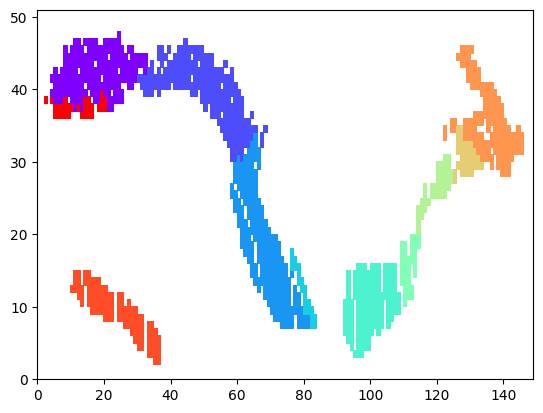

In [29]:
import matplotlib.pyplot as plt
from matplotlib import cm
plt.pcolor(mask_lme,cmap=cm.rainbow)
plt.show()

In [30]:
filename = f'{path}/FOSI_hindcast_EN4_T_LME_hori_regrid.nc'
ds2 = xr.open_dataset(filename)
mask_lme2 = ds2['lme_mask'].isel(y=range(14,65),x=range(169,318)).values
for nn,box in zip(range(len(lme)),lme):
    print(box)
    latloc, lonloc = np.where(np.abs(mask_lme2-box) <= 0.01)
    for bb in range(len(latloc)):
        if box == 65:
            box = 11
        mask_lme[latloc[bb], lonloc[bb]] = box
#mask_lme.mask[9,107]=True

1
2
3
4
5
6
7
8
9
10
65


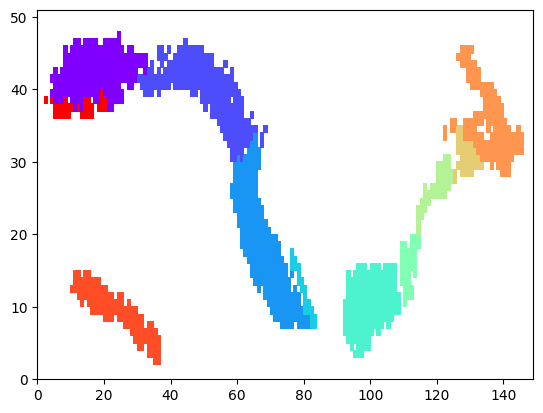

In [31]:
import matplotlib.pyplot as plt
from matplotlib import cm
plt.pcolor(mask_lme,cmap=cm.rainbow)
plt.show()

In [32]:
gobaio21 = dsf['EN4_T_0-200m'].values
gobaio22 = dsf['EN4_T_200-600m'].values
fosio21 = dsf['FOSI_T_0-200m'].values
fosio22 = dsf['FOSI_T_200-600m'].values
gobaio21 = np.ma.array(gobaio21,mask=np.isnan(gobaio21))
gobaio22 = np.ma.array(gobaio22,mask=np.isnan(gobaio22))
fosio21 = np.ma.array(fosio21,mask=np.isnan(fosio21))
fosio22 = np.ma.array(fosio22,mask=np.isnan(fosio22))

In [33]:
boxPhi = xr.Dataset()
phi_box1 = np.ma.zeros([len(lme), 768])
phi_box1.mask = True
phi_box2 = phi_box1.copy()
phi_box3 = phi_box1.copy()
phi_box4 = phi_box1.copy()
for nn,box in zip(range(len(lme)),lme):
    print(box)
    latloc, lonloc = np.where(mask_lme == (nn+1))
    ar1 = np.ma.zeros([len(latloc),768])
    ar2 = ar1.copy()
    ar3 = ar1.copy()
    ar4 = ar1.copy()
    for bb in range(len(latloc)):
        ar1[bb] = gobaio21[:,latloc[bb], lonloc[bb]]
        ar2[bb] = gobaio22[:,latloc[bb], lonloc[bb]]
        ar3[bb] = fosio21[:,latloc[bb], lonloc[bb]]
        ar4[bb] = fosio22[:,latloc[bb], lonloc[bb]]

    phi_box1[nn] = np.mean(ar1,axis=0)
    phi_box2[nn] = np.mean(ar2,axis=0)
    phi_box3[nn] = np.mean(ar3,axis=0)
    phi_box4[nn] = np.mean(ar4,axis=0)
boxPhi['EN4_T_0-200m'] = xr.DataArray(data=phi_box1, coords=dict(lme=('lme', lme), time=('time', range(768))), dims=('lme','time'))
boxPhi['EN4_T_200-600m'] = xr.DataArray(data=phi_box2, coords=dict(lme=('lme', lme), time=('time', range(768))), dims=('lme','time'))
boxPhi['FOSI_T_0-200m'] = xr.DataArray(data=phi_box3, coords=dict(lme=('lme', lme), time=('time', range(768))), dims=('lme','time'))
boxPhi['FOSI_T_200-600m'] = xr.DataArray(data=phi_box4, coords=dict(lme=('lme', lme), time=('time', range(768))), dims=('lme','time'))

1
2
3
4
5
6
7
8
9
10
65


In [34]:
boxPhi.load()

<xarray.Dataset>
Dimensions:          (lme: 11, time: 768)
Coordinates:
  * lme              (lme) int64 1 2 3 4 5 6 7 8 9 10 65
  * time             (time) int64 0 1 2 3 4 5 6 ... 761 762 763 764 765 766 767
Data variables:
    EN4_T_0-200m     (lme, time) float64 2.968 2.322 2.098 ... 5.684 5.426 4.907
    EN4_T_200-600m   (lme, time) float64 3.622 3.557 3.544 ... 3.93 3.909 3.914
    FOSI_T_0-200m    (lme, time) float64 2.373 1.69 1.289 ... 6.077 5.805 5.333
    FOSI_T_200-600m  (lme, time) float64 4.741 4.745 4.741 ... 4.913 4.913 4.913

In [35]:
boxPhi.to_netcdf(f'{path}/EN4_FOSI_T_LME_mean_195401-201712_monthly.nc', mode='w')

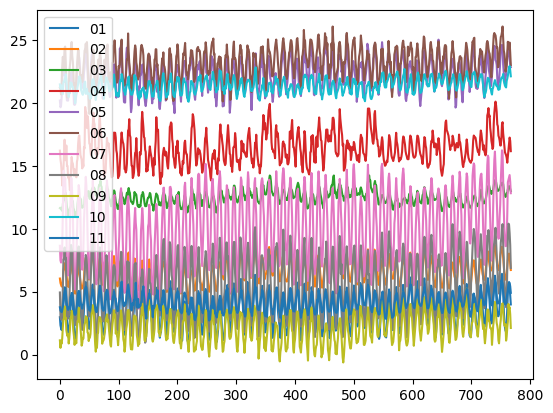

In [36]:
plt.plot(phi_box1.T)
plt.legend(['01','02','03','04','05','06','07','08','09','10','11'])
plt.show()